In [103]:
!pip install matplotlib
!pip install ipywidgets

import requests
from datetime import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve RDI data from FRED API
api_key = os.environ.get('api_key')  # Fetch the API key from environment variables
series_id = "A229RX0"
today = datetime.today().strftime('%Y-%m-%d')
url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start=1960-01-01&observation_end={today}&frequency=a"

# Send a request to the FRED API and get the JSON response
response = requests.get(url)
data = response.json()["observations"]

In [104]:
# Define the presidents' names dictionary with start and end years
presidents = {
    (1960, 1964): 'John F. Kennedy',
    (1964, 1968): 'Lyndon B. Johnson',
    (1968, 1972): 'Richard Nixon - 1st term',
    (1972, 1976): 'Richard Nixon - 2nd term / 1974-1976: Gerald Ford',
    (1976, 1980): 'Jimmy Carter',
    (1980, 1984): 'Ronald Reagan - 1st term',
    (1984, 1988): 'Ronald Reagan - 2nd term',
    (1988, 1992): 'George H.W. Bush',
    (1992, 1996): 'Bill Clinton - 1st term',
    (1996, 2000): 'Bill Clinton - 2nd term',
    (2000, 2004): 'George W. Bush - 1st term',
    (2004, 2008): 'George W. Bush - 2nd term',
    (2008, 2012): 'Barack Obama - 1st term',
    (2012, 2016): 'Barack Obama - 2nd term',
    (2016, 2020): 'Donald Trump',
    (2020, 2024): 'Joe Biden'
}

# Define a function to get the president's name for a given year
def get_president_name(year):
    year = int(year)
    for (start_year, end_year), president_name in presidents.items():
        if start_year <= year < end_year:
            return president_name
    return None

# Extract RDI data and create DataFrame
rdi_dict = {}
data_sorted = sorted(data, key=lambda x: x['date'])  # Sort data by year
for year_data in data_sorted:
    year = year_data['date'][:4]  # Extract year from date
    rdi_value = year_data['value']  # Assuming 'value' field contains RDI data
    if rdi_value is None or not rdi_value.isnumeric():
        rdi_dict[year] = None
    else:
        rdi_dict[year] = float(rdi_value)

# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(rdi_dict, orient='index', columns=['usvalue'])
df.index.name = 'date'  # Rename the 'year' column to 'date'
# Add the 'presidents' column based on the assigned names using apply function
df['presidents'] = df.index.map(get_president_name)
df['growthvalue'] = np.log(df['usvalue'] / df['usvalue'].shift()) * 100

# Add the 'presidents' column based on the 'presidents' dictionary
#df['presidents'] = df.index.map(lambda x: presidents.get(int(x), None))

# Add the 'fecha' column with the UTC year and month encoding
df['utcyymm'] = [f"{year_data['date'][:4]}-{year_data['date'][5:7]}" for year_data in data_sorted]

# Rearrange the columns in the specified order
df = df[['utcyymm', 'usvalue', 'growthvalue', 'presidents']]

# Save the DataFrame as a CSV file
#file_path = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/df_data.csv"
#df.to_csv(file_path)
file_path2 = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/docs/assets/charts/data/df_data.csv"
df.to_csv(file_path2)

In [90]:
import pandas as pd

dropbox_url = "https://www.dropbox.com/scl/fi/s17h2uz3pxaqffbnrcxy7/df_vote.csv?rlkey=ostwpsa0m6syqzke0kpkwf892&dl=1"

# Download the CSV content using pandas
df_vote = pd.read_csv(dropbox_url, index_col=0)  # Assuming index is in the first column

# Convert the index 'year' to datetime objects
#df_vote.index = pd.to_datetime(df_vote.index, format='%Y')

# Modify the index to only include year and month (e.g., "1944-01")
#df_vote.index = df_vote.index.to_period('M')

file_path3 = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/docs/assets/charts/data/df_vote.csv"
df_vote.to_csv(file_path3, index=True)  # Save without index

print(df_vote.head())

       economy  RDI_y  RDI_1  RDI_2  RDI_3  RDI_4    demvote    repvote  \
year                                                                      
1944  5.704023    2.3   13.0   10.7    3.1    2.3  53.400002  45.900002   
1948  2.241379    3.5   -2.4   -1.9   -5.8    3.5  49.549999  45.070000   
1952  5.632184    1.5   -1.1    7.0    1.2    1.5  44.380001  55.130001   
1956  6.609196    3.0    3.1   -0.4    4.8    3.0  41.950001  57.380001   
1960  3.477012    0.6    0.6   -0.7    2.6    0.6  49.720001  49.549999   

      incterms  dem_inc   gnp3  gnp4    incvote  _merge  inc_margin  
year                                                                 
1944         3        1  13.69  6.48  53.400002       3    7.500000  
1948         4        1  -2.96  2.49  49.549999       3    4.479999  
1952         5        1   5.72  1.96  44.380001       3  -10.750000  
1956         1        0   5.14  0.21  57.380001       3   15.430000  
1960         2        0   5.45  0.82  49.549999       

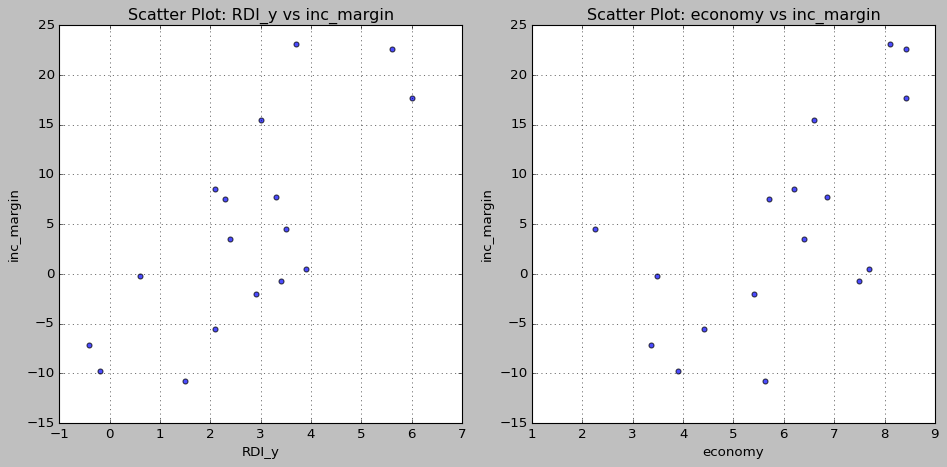

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')  # Set the classic style

# Assuming you have already read the CSV and have the DataFrame df_vote

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of RDI_y against inc_margin
axs[0].scatter(df_vote['RDI_y'], df_vote['inc_margin'], alpha=0.7)
axs[0].set_title('Scatter Plot: RDI_y vs inc_margin')
axs[0].set_xlabel('RDI_y')
axs[0].set_ylabel('inc_margin')
axs[0].grid(True)

# Scatter plot of economy against inc_margin
axs[1].scatter(df_vote['economy'], df_vote['inc_margin'], alpha=0.7)
axs[1].set_title('Scatter Plot: economy vs inc_margin')
axs[1].set_xlabel('economy')
axs[1].set_ylabel('inc_margin')
axs[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_15444\2888708876.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


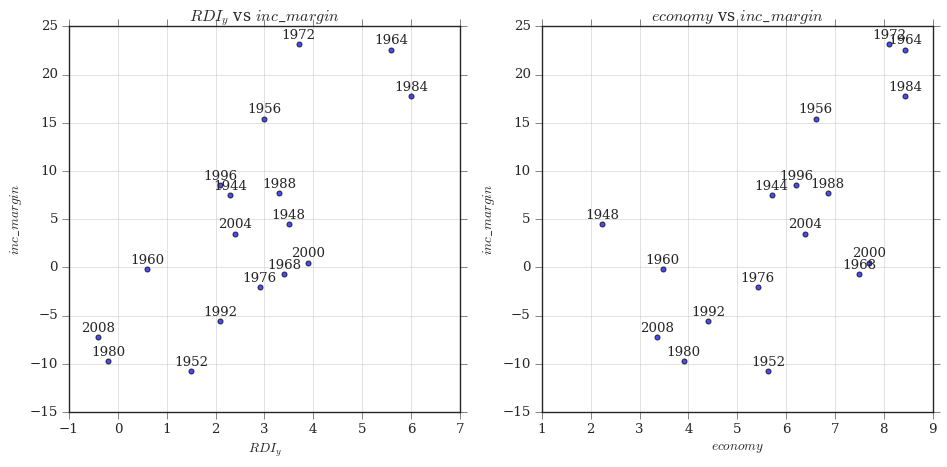

In [93]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

dropbox_url = "https://www.dropbox.com/scl/fi/s17h2uz3pxaqffbnrcxy7/df_vote.csv?rlkey=ostwpsa0m6syqzke0kpkwf892&dl=1"

# Download the CSV content using pandas
df_vote = pd.read_csv(dropbox_url, index_col=0)

# Set LaTeX-like theme
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'serif'

# Assuming you have already read the CSV and have the DataFrame df_vote

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of RDI_y against inc_margin with year labels (on the left)
axs[0].scatter(df_vote['RDI_y'], df_vote['inc_margin'], alpha=0.7)
for i, row in df_vote.iterrows():
    year_str = str(i)  # Convert index year to string
    axs[0].annotate(year_str, (row['RDI_y'], row['inc_margin']), textcoords="offset points", xytext=(0,5), ha='center')
axs[0].set_title('$RDI_y$ vs $inc\_margin$')
axs[0].set_xlabel('$RDI_y$')
axs[0].set_ylabel('$inc\_margin$')
axs[0].grid(True)

# Scatter plot of economy against inc_margin with year labels (on the right)
axs[1].scatter(df_vote['economy'], df_vote['inc_margin'], alpha=0.7)
for i, row in df_vote.iterrows():
    year_str = str(i)  # Convert index year to string
    axs[1].annotate(year_str, (row['economy'], row['inc_margin']), textcoords="offset points", xytext=(0,5), ha='center')
axs[1].set_title('$economy$ vs $inc\_margin$')
axs[1].set_xlabel('$economy$')
axs[1].set_ylabel('$inc\_margin$')
axs[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
#plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\incmarg.png")

# Display the saved plot
plt.show()

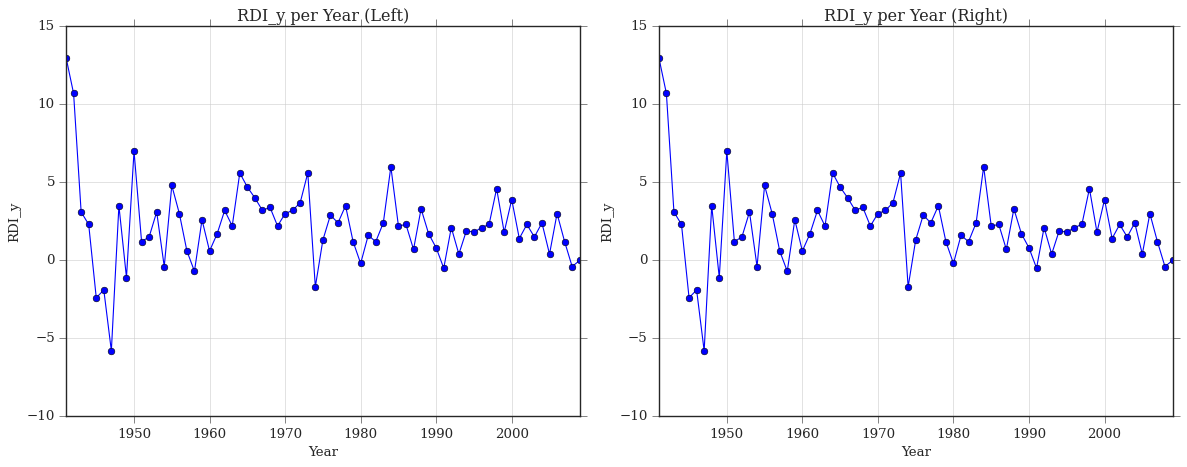

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Read the CSV data
dropbox_urlF = "https://www.dropbox.com/scl/fi/5c2jkx2eeai2qfcbcwxcf/df_voteF.csv?rlkey=1io0vhhbu2wn1zbiyvsqsh7n8&dl=1"
df_voteF = pd.read_csv(dropbox_urlF)
df_voteF['year'] = pd.to_datetime(df_voteF['year'], format='%Y')

# Set up a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot on the left subplot
axs[0].plot(df_voteF['year'], df_voteF['RDI_y'], marker='o')
axs[0].set_title('RDI_y per Year (Left)')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('RDI_y')

# Format x-axis labels as years
date_form = DateFormatter("%Y")
axs[0].xaxis.set_major_formatter(date_form)
axs[0].grid(True)

# Plot on the right subplot (identical to the left)
axs[1].plot(df_voteF['year'], df_voteF['RDI_y'], marker='o')
axs[1].set_title('RDI_y per Year (Right)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('RDI_y')

# Format x-axis labels as years
axs[1].xaxis.set_major_formatter(date_form)
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


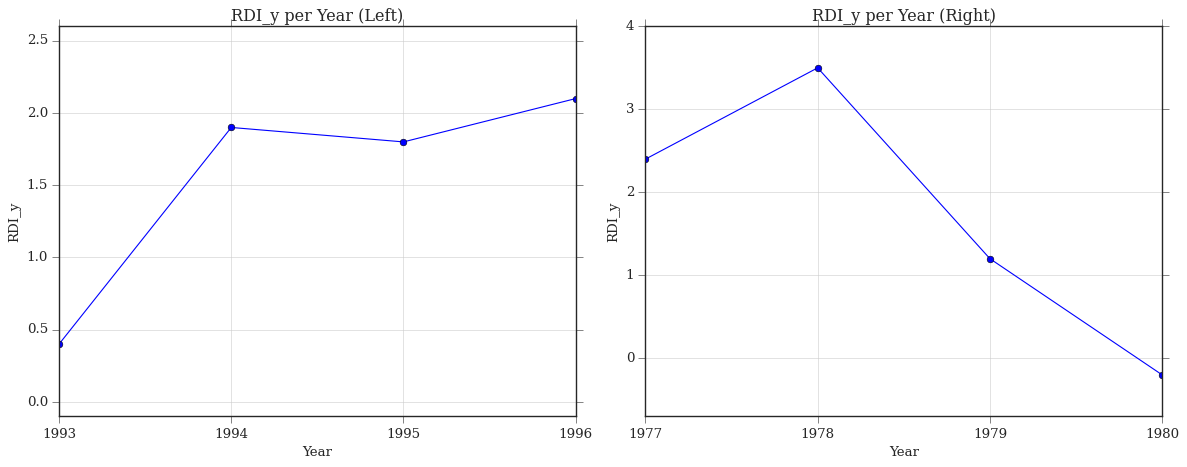

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator

# Read the CSV data
dropbox_urlF = "https://www.dropbox.com/scl/fi/5c2jkx2eeai2qfcbcwxcf/df_voteF.csv?rlkey=1io0vhhbu2wn1zbiyvsqsh7n8&dl=1"
df_voteF = pd.read_csv(dropbox_urlF)
df_voteF['year'] = pd.to_datetime(df_voteF['year'], format='%Y')

# Filter data for the left plot (1993 to 1996)
left_data = df_voteF[(df_voteF['year'] >= '1993') & (df_voteF['year'] <= '1996')]

# Filter data for the right plot (1977 to 1980)
right_data = df_voteF[(df_voteF['year'] >= '1977') & (df_voteF['year'] <= '1980')]

# Set up a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot on the left subplot
axs[0].plot(left_data['year'], left_data['RDI_y'], marker='o')
axs[0].set_title('RDI_y per Year (Left)')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('RDI_y')

# Format x-axis labels as years
date_form = DateFormatter("%Y")
axs[0].xaxis.set_major_formatter(date_form)
axs[0].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[0].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[0].set_xlim(left_data['year'].min(), left_data['year'].max())
axs[0].set_ylim(left_data['RDI_y'].min() - 0.5, left_data['RDI_y'].max() + 0.5)

# Plot on the right subplot (1977 to 1980)
axs[1].plot(right_data['year'], right_data['RDI_y'], marker='o')
axs[1].set_title('RDI_y per Year (Right)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('RDI_y')

# Format x-axis labels as years
axs[1].xaxis.set_major_formatter(date_form)
axs[1].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[1].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[1].set_xlim(right_data['year'].min(), right_data['year'].max())
axs[1].set_ylim(right_data['RDI_y'].min() - 0.5, right_data['RDI_y'].max() + 0.5)

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\clintoncarter.png")
plt.show()

In [106]:
print(df_voteF)

         year    rdi  RDI_y  RDI_1  RDI_2  RDI_3  RDI_4  \
0  1940-01-01   6953    NaN    NaN    NaN    NaN    NaN   
1  1941-01-01   7918   13.0    NaN    NaN    NaN   13.0   
2  1942-01-01   8808   10.7    NaN    NaN   13.0   10.7   
3  1943-01-01   9087    3.1    NaN   13.0   10.7    3.1   
4  1944-01-01   9301    2.3   13.0   10.7    3.1    2.3   
..        ...    ...    ...    ...    ...    ...    ...   
65 2005-01-01  31318    0.4    2.3    1.5    2.4    0.4   
66 2006-01-01  32271    3.0    1.5    2.4    0.4    3.0   
67 2007-01-01  32648    1.2    2.4    0.4    3.0    1.2   
68 2008-01-01  32514   -0.4    0.4    3.0    1.2   -0.4   
69 2009-01-01  32519    0.0    3.0    1.2   -0.4    0.0   

                                       presidents  
0   "1940-1944": Franklin D. Roosevelt - 3rd term  
1   "1940-1944": Franklin D. Roosevelt - 3rd term  
2   "1940-1944": Franklin D. Roosevelt - 3rd term  
3   "1940-1944": Franklin D. Roosevelt - 3rd term  
4   "1944-1948": Franklin D. Ro

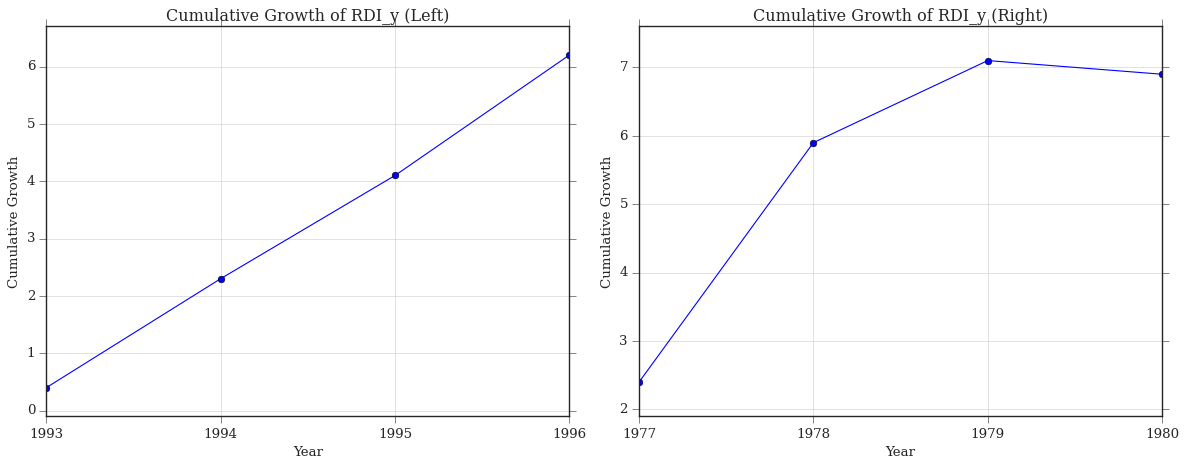

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator

# Read the CSV data
dropbox_urlF = "https://www.dropbox.com/scl/fi/5c2jkx2eeai2qfcbcwxcf/df_voteF.csv?rlkey=1io0vhhbu2wn1zbiyvsqsh7n8&dl=1"
df_voteF = pd.read_csv(dropbox_urlF)
df_voteF['year'] = pd.to_datetime(df_voteF['year'], format='%Y')

# Calculate the cumulative growth of RDI_y in 4-year terms
df_voteF['cumulative_growth'] = df_voteF.groupby((df_voteF['year'].dt.year - 1) // 4 * 4)['RDI_y'].cumsum()

# Filter data for the left plot (1993 to 1996)
left_data = df_voteF[(df_voteF['year'] >= '1993') & (df_voteF['year'] <= '1996')]

# Filter data for the right plot (1977 to 1980)
right_data = df_voteF[(df_voteF['year'] >= '1977') & (df_voteF['year'] <= '1980')]

# Set up a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot cumulative growth on the left subplot
axs[0].plot(left_data['year'], left_data['cumulative_growth'], marker='o')
axs[0].set_title('Cumulative Growth of RDI_y (Left)')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Cumulative Growth')

# Format x-axis labels as years
date_form = DateFormatter("%Y")
axs[0].xaxis.set_major_formatter(date_form)
axs[0].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[0].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[0].set_xlim(left_data['year'].min(), left_data['year'].max())
axs[0].set_ylim(left_data['cumulative_growth'].min() - 0.5, left_data['cumulative_growth'].max() + 0.5)

# Plot cumulative growth on the right subplot
axs[1].plot(right_data['year'], right_data['cumulative_growth'], marker='o')
axs[1].set_title('Cumulative Growth of RDI_y (Right)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Cumulative Growth')

# Format x-axis labels as years
axs[1].xaxis.set_major_formatter(date_form)
axs[1].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[1].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[1].set_xlim(right_data['year'].min(), right_data['year'].max())
axs[1].set_ylim(right_data['cumulative_growth'].min() - 0.5, right_data['cumulative_growth'].max() + 0.5)

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\clintoncarter_cumulative.png")
plt.show()


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_15444\600054834.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_data['cumulative_growth'] = left_data.groupby((left_data['year'].dt.year - 1) // 4 * 4)['RDI_y'].cumsum()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_15444\600054834.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_data['cumulative_growth'] = right_data.groupby((right_data['year'].dt.year - 1) // 4 * 4)['RDI_y'].cumsum()


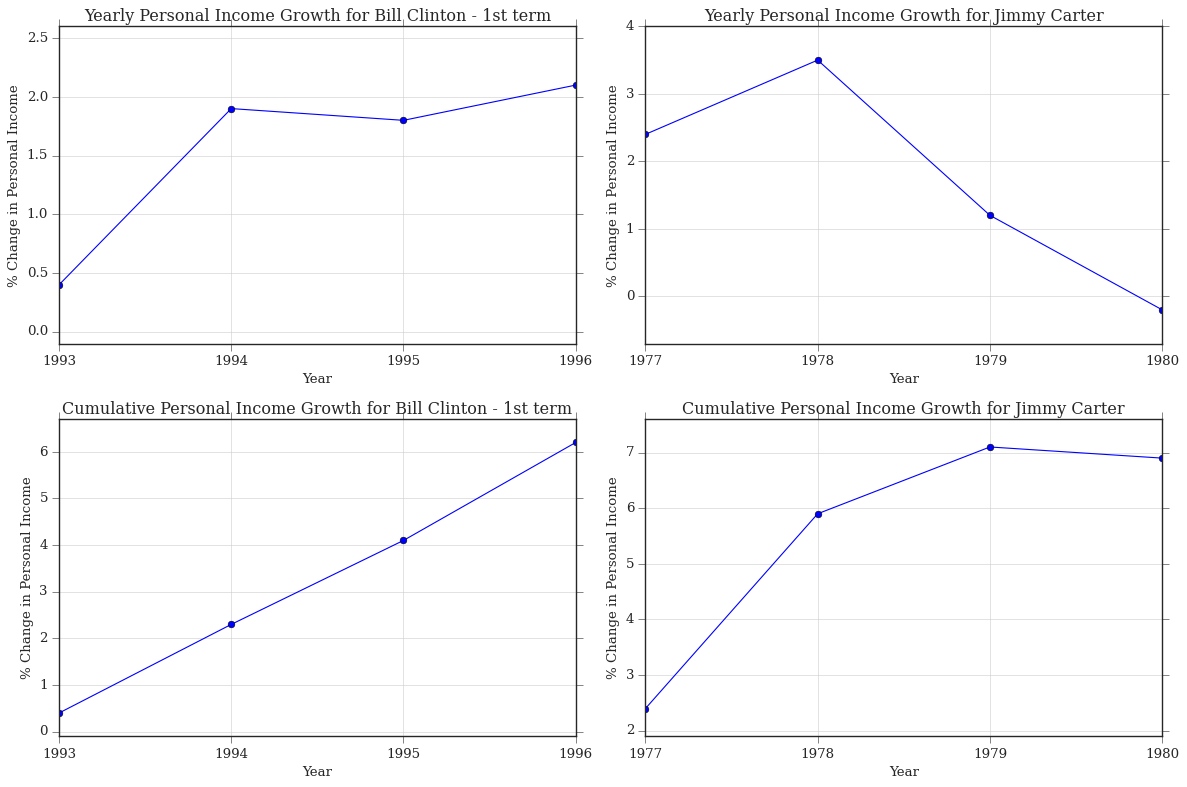

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator

# Read the CSV data
dropbox_urlF = "https://www.dropbox.com/scl/fi/5c2jkx2eeai2qfcbcwxcf/df_voteF.csv?rlkey=1io0vhhbu2wn1zbiyvsqsh7n8&dl=1"
df_voteF = pd.read_csv(dropbox_urlF)
df_voteF['year'] = pd.to_datetime(df_voteF['year'], format='%Y')

# Filter data for the left plot (1993 to 1996)
left_data = df_voteF[(df_voteF['year'] >= '1993') & (df_voteF['year'] <= '1996')]

# Filter data for the right plot (1977 to 1980)
right_data = df_voteF[(df_voteF['year'] >= '1977') & (df_voteF['year'] <= '1980')]

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot on the top-left subplot
axs[0, 0].plot(left_data['year'], left_data['RDI_y'], marker='o')
axs[0, 0].set_title('Yearly Personal Income Growth for Bill Clinton - 1st term')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('% Change in Personal Income')

# Format x-axis labels as years
date_form = DateFormatter("%Y")
axs[0, 0].xaxis.set_major_formatter(date_form)
axs[0, 0].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[0, 0].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[0, 0].set_xlim(left_data['year'].min(), left_data['year'].max())
axs[0, 0].set_ylim(left_data['RDI_y'].min() - 0.5, left_data['RDI_y'].max() + 0.5)

# Plot on the top-right subplot
axs[0, 1].plot(right_data['year'], right_data['RDI_y'], marker='o')
axs[0, 1].set_title('Yearly Personal Income Growth for Jimmy Carter')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('% Change in Personal Income')

# Format x-axis labels as years
axs[0, 1].xaxis.set_major_formatter(date_form)
axs[0, 1].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[0, 1].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[0, 1].set_xlim(right_data['year'].min(), right_data['year'].max())
axs[0, 1].set_ylim(right_data['RDI_y'].min() - 0.5, right_data['RDI_y'].max() + 0.5)

# Calculate the cumulative growth of RDI_y in 4-year terms
left_data['cumulative_growth'] = left_data.groupby((left_data['year'].dt.year - 1) // 4 * 4)['RDI_y'].cumsum()
right_data['cumulative_growth'] = right_data.groupby((right_data['year'].dt.year - 1) // 4 * 4)['RDI_y'].cumsum()

# Plot cumulative growth on the bottom-left subplot
axs[1, 0].plot(left_data['year'], left_data['cumulative_growth'], marker='o')
axs[1, 0].set_title('Cumulative Personal Income Growth for Bill Clinton - 1st term')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('% Change in Personal Income')

# Format x-axis labels as years
axs[1, 0].xaxis.set_major_formatter(date_form)
axs[1, 0].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[1, 0].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[1, 0].set_xlim(left_data['year'].min(), left_data['year'].max())
axs[1, 0].set_ylim(left_data['cumulative_growth'].min() - 0.5, left_data['cumulative_growth'].max() + 0.5)

# Plot cumulative growth on the bottom-right subplot
axs[1, 1].plot(right_data['year'], right_data['cumulative_growth'], marker='o')
axs[1, 1].set_title('Cumulative Personal Income Growth for Jimmy Carter')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('% Change in Personal Income')

# Format x-axis labels as years
axs[1, 1].xaxis.set_major_formatter(date_form)
axs[1, 1].xaxis.set_major_locator(YearLocator(base=1))  # Display every year
axs[1, 1].grid(True)

# Adjust x-axis and y-axis limits for more space
axs[1, 1].set_xlim(right_data['year'].min(), right_data['year'].max())
axs[1, 1].set_ylim(right_data['cumulative_growth'].min() - 0.5, right_data['cumulative_growth'].max() + 0.5)

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\clintoncarter_combined.png")
plt.show()


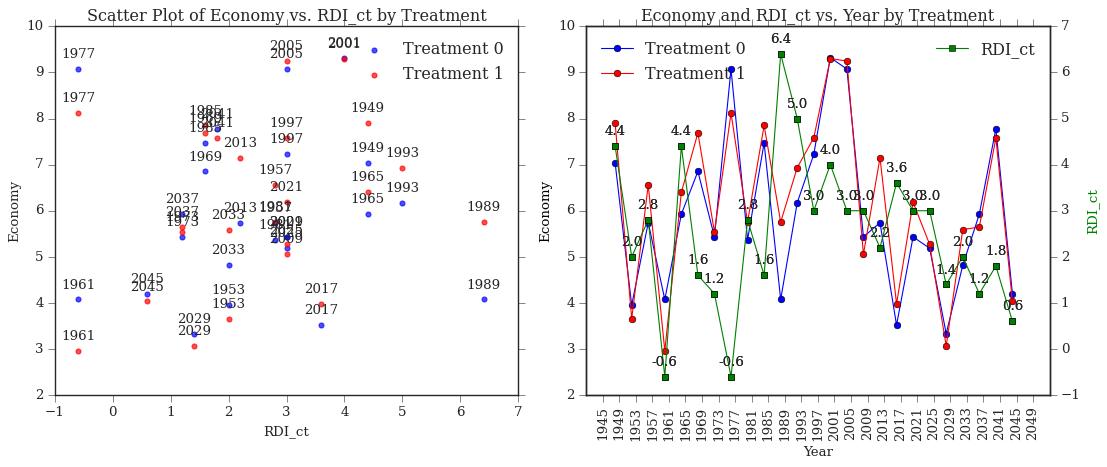

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Convert 'year' column to datetime format
df_cum['year'] = pd.to_datetime(df_cum['year'], format='%Y')

# Define the x-axis tick positions and labels
x_ticks = pd.date_range(start='1945-01-01', end='2050-01-01', freq='4Y')

# Create separate dataframes for each treatment
df_treatment_0 = df_cum[df_cum['treatment'] == 0]
df_treatment_1 = df_cum[df_cum['treatment'] == 1]

# Create a scatter plot for Treatment 0 and 1 (left)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot (Scatter Plot of Economy vs. RDI_ct by Treatment)
ax1.scatter(df_treatment_0['RDI_ct'], df_treatment_0['economy'], label='Treatment 0', color='blue', alpha=0.7)
ax1.scatter(df_treatment_1['RDI_ct'], df_treatment_1['economy'], label='Treatment 1', color='red', alpha=0.7)

# Add data labels for each year (converting year to int)
for i, row in df_cum.iterrows():
    year_int = int(row['year'].year)  # Get the year component
    ax1.annotate(year_int, (row['RDI_ct'], row['economy']), textcoords="offset points", xytext=(0,10), ha='center')

ax1.set_xlabel('RDI_ct')
ax1.set_ylabel('Economy')
ax1.set_title('Scatter Plot of Economy vs. RDI_ct by Treatment')
ax1.legend()

# Right plot (Combined Plot with Secondary Y-axis)
# Plot Economy vs. Year by Treatment (primary y-axis)
ax2.plot(df_treatment_0['year'], df_treatment_0['economy'], label='Treatment 0', color='blue', marker='o')
ax2.plot(df_treatment_1['year'], df_treatment_1['economy'], label='Treatment 1', color='red', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Economy', color='black')  # Primary y-axis label
ax2.set_title('Economy and RDI_ct vs. Year by Treatment')
ax2.legend(loc='upper left')

# Create a secondary y-axis for RDI_ct
ax3 = ax2.twinx()  # Create a twin y-axis sharing the same x-axis
ax3.plot(df_cum['year'], df_cum['RDI_ct'], label='RDI_ct', color='green', marker='s')

# Add data labels for RDI_ct values
for i, row in df_cum.iterrows():
    rdi_ct = row['RDI_ct']  # RDI_ct value
    ax3.annotate(rdi_ct, (row['year'], row['RDI_ct']), textcoords="offset points", xytext=(0,10), ha='center')

ax3.set_ylabel('RDI_ct', color='green')  # Secondary y-axis label
ax3.legend(loc='upper right')

# Format the x-axis with exact year values and additional space
ax2.set_xticks(x_ticks)
ax2.set_xlim(x_ticks[0] - pd.DateOffset(years=4), x_ticks[-1] + pd.DateOffset(years=4))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter(''))

# Rotate x-axis labels vertically
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\difcum.png")
plt.show()


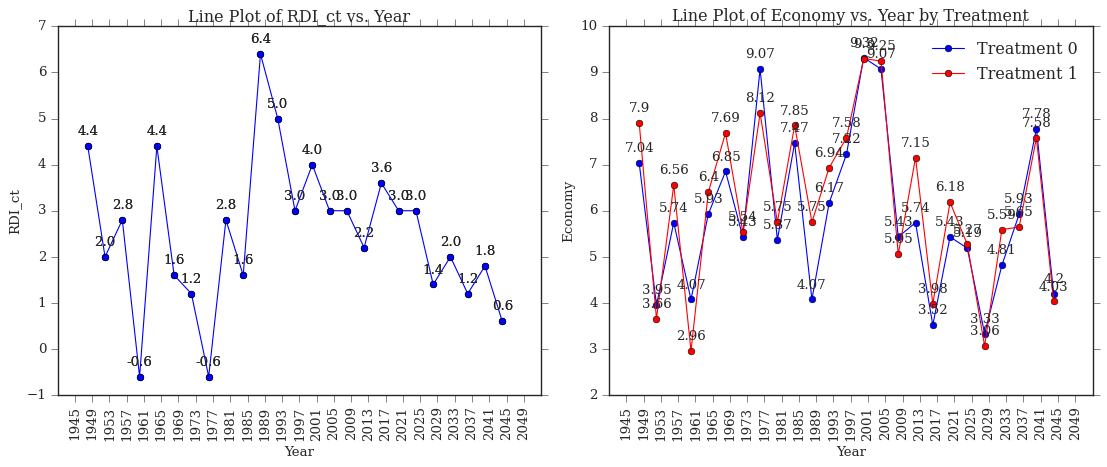

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Convert 'year' column to datetime format
df_cum['year'] = pd.to_datetime(df_cum['year'], format='%Y')

# Define the x-axis tick positions and labels
x_ticks = pd.date_range(start='1945-01-01', end='2050-01-01', freq='4Y')

# Create a line plot for RDI_ct over the years (left)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1x2 subplot grid

# Left plot (RDI_ct vs. Year)
ax1.plot(df_cum['year'], df_cum['RDI_ct'], color='blue', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('RDI_ct')
ax1.set_title('Line Plot of RDI_ct vs. Year')
#ax1.grid(True)

# Add data labels for each point in the left plot
for i, row in df_cum.iterrows():
    ax1.annotate(round(row['RDI_ct'], 2), (row['year'], row['RDI_ct']), textcoords="offset points", xytext=(0,10), ha='center')

# Right plot (Economy vs. Year by Treatment)
ax2.plot(df_treatment_0['year'], df_treatment_0['economy'], label='Treatment 0', color='blue', marker='o')
ax2.plot(df_treatment_1['year'], df_treatment_1['economy'], label='Treatment 1', color='red', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Economy')
ax2.set_title('Line Plot of Economy vs. Year by Treatment')
ax2.legend()

# Format the x-axis with exact year values and additional space
ax1.set_xticks(x_ticks)
ax1.set_xlim(x_ticks[0] - pd.DateOffset(years=4), x_ticks[-1] + pd.DateOffset(years=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter(''))

# Format the x-axis for the right plot to match the left plot
ax2.set_xticks(x_ticks)
ax2.set_xlim(x_ticks[0] - pd.DateOffset(years=4), x_ticks[-1] + pd.DateOffset(years=4))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter(''))

# Rotate x-axis labels vertically in both plots
for ax in [ax1, ax2]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

# Add data labels for each point in the right plot
for i, row in df_cum.iterrows():
    ax2.annotate(round(row['economy'], 2), (row['year'], row['economy']), textcoords="offset points", xytext=(0,10), ha='center')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\difcum2.png")
plt.show()


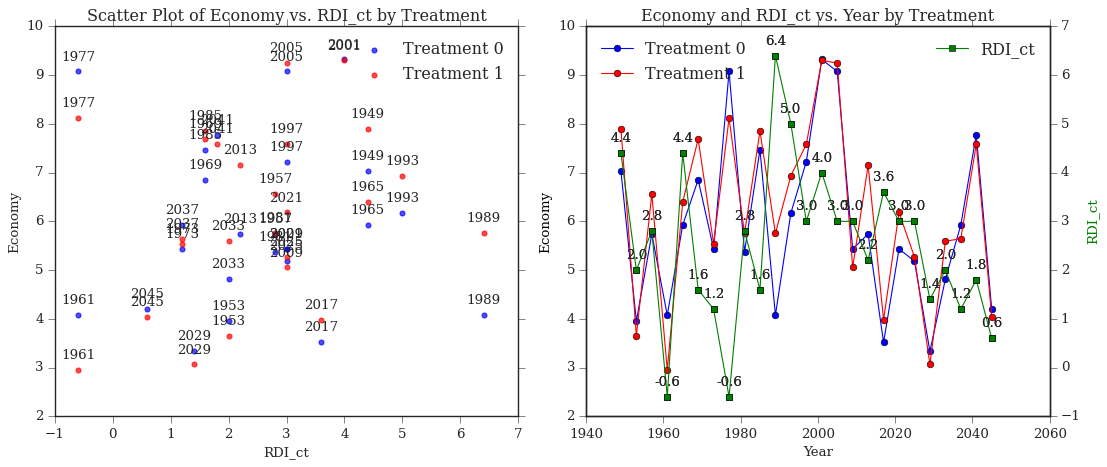

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Create separate dataframes for each treatment
df_treatment_0 = df_cum[df_cum['treatment'] == 0]
df_treatment_1 = df_cum[df_cum['treatment'] == 1]

# Create a scatter plot for Treatment 0 and 1 (left)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot (Scatter Plot of Economy vs. RDI_ct by Treatment)
ax1.scatter(df_treatment_0['RDI_ct'], df_treatment_0['economy'], label='Treatment 0', color='blue', alpha=0.7)
ax1.scatter(df_treatment_1['RDI_ct'], df_treatment_1['economy'], label='Treatment 1', color='red', alpha=0.7)

# Add data labels for each year (converting year to int)
for i, row in df_cum.iterrows():
    year_int = int(row['year'])  # Convert year to integer
    ax1.annotate(year_int, (row['RDI_ct'], row['economy']), textcoords="offset points", xytext=(0,10), ha='center')

ax1.set_xlabel('RDI_ct')
ax1.set_ylabel('Economy')
ax1.set_title('Scatter Plot of Economy vs. RDI_ct by Treatment')
ax1.legend()

# Right plot (Combined Plot with Secondary Y-axis)
# Plot Economy vs. Year by Treatment (primary y-axis)
ax2.plot(df_treatment_0['year'], df_treatment_0['economy'], label='Treatment 0', color='blue', marker='o')
ax2.plot(df_treatment_1['year'], df_treatment_1['economy'], label='Treatment 1', color='red', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Economy', color='black')  # Primary y-axis label
ax2.set_title('Economy and RDI_ct vs. Year by Treatment')
ax2.legend(loc='upper left')

# Create a secondary y-axis for RDI_ct
ax3 = ax2.twinx()  # Create a twin y-axis sharing the same x-axis
ax3.plot(df_cum['year'], df_cum['RDI_ct'], label='RDI_ct', color='green', marker='s')

# Add data labels for RDI_ct values
for i, row in df_cum.iterrows():
    rdi_ct = row['RDI_ct']  # RDI_ct value
    ax3.annotate(rdi_ct, (row['year'], row['RDI_ct']), textcoords="offset points", xytext=(0,10), ha='center')

ax3.set_ylabel('RDI_ct', color='green')  # Secondary y-axis label
ax3.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\difcum.png")
plt.show()


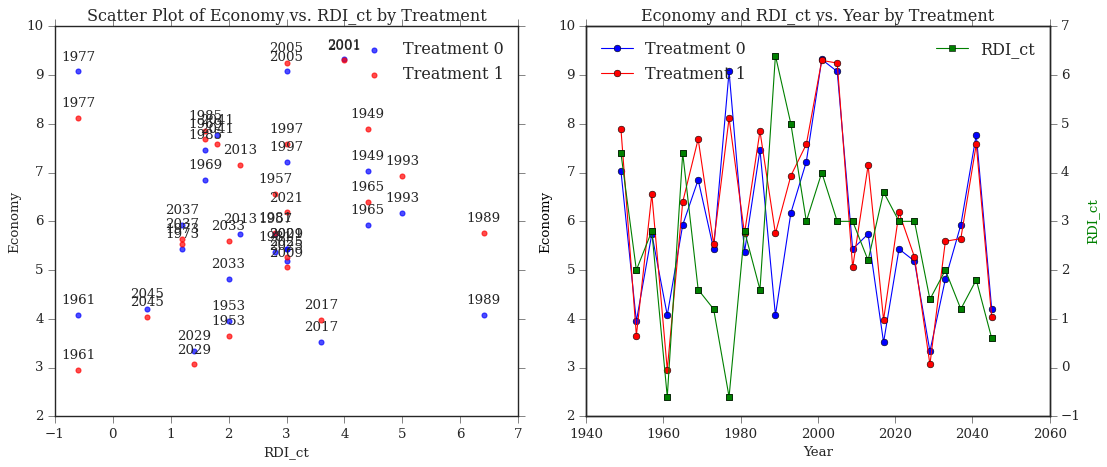

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Create separate dataframes for each treatment
df_treatment_0 = df_cum[df_cum['treatment'] == 0]
df_treatment_1 = df_cum[df_cum['treatment'] == 1]

# Create a scatter plot for Treatment 0 and 1 (left)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot (Scatter Plot of Economy vs. RDI_ct by Treatment)
ax1.scatter(df_treatment_0['RDI_ct'], df_treatment_0['economy'], label='Treatment 0', color='blue', alpha=0.7)
ax1.scatter(df_treatment_1['RDI_ct'], df_treatment_1['economy'], label='Treatment 1', color='red', alpha=0.7)

# Add data labels for each year (converting year to int)
for i, row in df_cum.iterrows():
    year_int = int(row['year'])  # Convert year to integer
    ax1.annotate(year_int, (row['RDI_ct'], row['economy']), textcoords="offset points", xytext=(0,10), ha='center')

ax1.set_xlabel('RDI_ct')
ax1.set_ylabel('Economy')
ax1.set_title('Scatter Plot of Economy vs. RDI_ct by Treatment')
ax1.legend()

# Right plot (Combined Plot with Secondary Y-axis)
# Plot Economy vs. Year by Treatment (primary y-axis)
ax2.plot(df_treatment_0['year'], df_treatment_0['economy'], label='Treatment 0', color='blue', marker='o')
ax2.plot(df_treatment_1['year'], df_treatment_1['economy'], label='Treatment 1', color='red', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Economy', color='black')  # Primary y-axis label
ax2.set_title('Economy and RDI_ct vs. Year by Treatment')
ax2.legend(loc='upper left')

# Create a secondary y-axis for RDI_ct
ax3 = ax2.twinx()  # Create a twin y-axis sharing the same x-axis
ax3.plot(df_cum['year'], df_cum['RDI_ct'], label='RDI_ct', color='green', marker='s')
ax3.set_ylabel('RDI_ct', color='green')  # Secondary y-axis label
ax3.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\difcum.png")
plt.show()


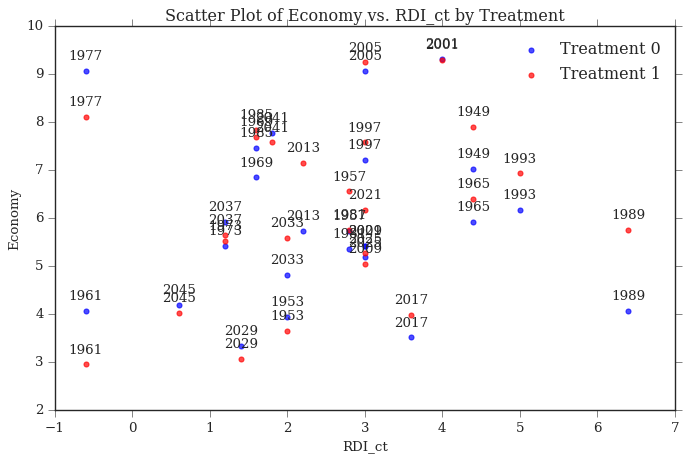

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Create separate dataframes for each treatment
df_treatment_0 = df_cum[df_cum['treatment'] == 0]
df_treatment_1 = df_cum[df_cum['treatment'] == 1]

# Create the scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(df_treatment_0['RDI_ct'], df_treatment_0['economy'], label='Treatment 0', color='blue', alpha=0.7)
plt.scatter(df_treatment_1['RDI_ct'], df_treatment_1['economy'], label='Treatment 1', color='red', alpha=0.7)

# Add data labels for each year (converting year to int)
for i, row in df_cum.iterrows():
    year_int = int(row['year'])  # Convert year to integer
    plt.annotate(year_int, (row['RDI_ct'], row['economy']), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('RDI_ct')
plt.ylabel('Economy')
plt.title('Scatter Plot of Economy vs. RDI_ct by Treatment')
plt.legend()

plt.show()


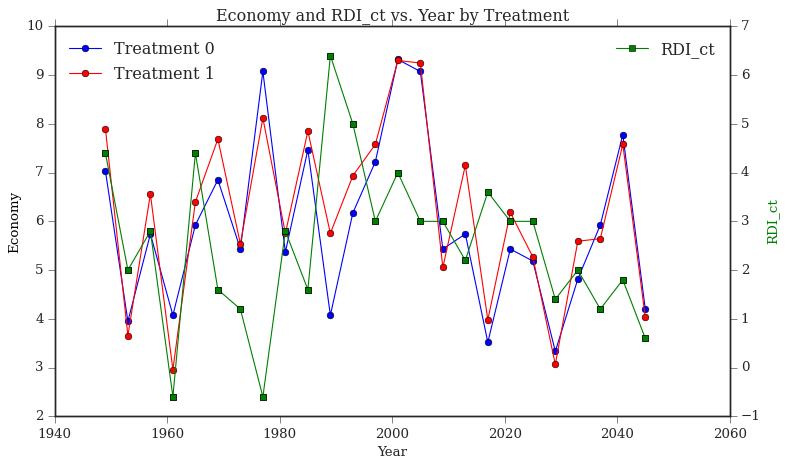

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Create separate dataframes for each treatment
df_treatment_0 = df_cum[df_cum['treatment'] == 0]
df_treatment_1 = df_cum[df_cum['treatment'] == 1]

# Create a figure with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Economy vs. Year by Treatment (primary y-axis)
ax1.plot(df_treatment_0['year'], df_treatment_0['economy'], label='Treatment 0', color='blue', marker='o')
ax1.plot(df_treatment_1['year'], df_treatment_1['economy'], label='Treatment 1', color='red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Economy', color='black')  # Primary y-axis label
ax1.set_title('Economy and RDI_ct vs. Year by Treatment')
ax1.legend(loc='upper left')

# Create a secondary y-axis for RDI_ct
ax2 = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax2.plot(df_cum['year'], df_cum['RDI_ct'], label='RDI_ct', color='green', marker='s')
ax2.set_ylabel('RDI_ct', color='green')  # Secondary y-axis label
ax2.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


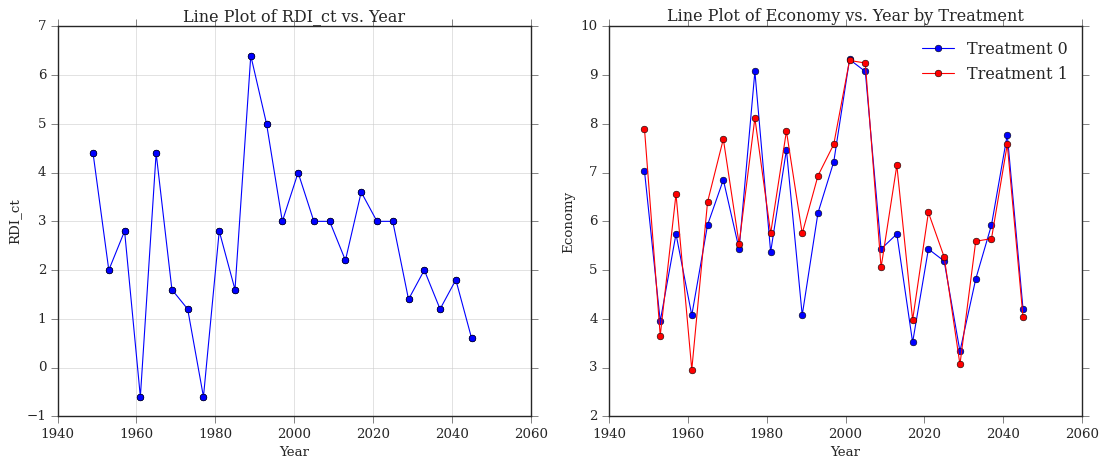

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Create a line plot for RDI_ct over the years (left)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1x2 subplot grid

# Left plot (RDI_ct vs. Year)
ax1.plot(df_cum['year'], df_cum['RDI_ct'], color='blue', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('RDI_ct')
ax1.set_title('Line Plot of RDI_ct vs. Year')
ax1.grid(True)

# Create separate dataframes for each treatment
df_treatment_0 = df_cum[df_cum['treatment'] == 0]
df_treatment_1 = df_cum[df_cum['treatment'] == 1]

# Right plot (Economy vs. Year by Treatment)
ax2.plot(df_treatment_0['year'], df_treatment_0['economy'], label='Treatment 0', color='blue', marker='o')
ax2.plot(df_treatment_1['year'], df_treatment_1['economy'], label='Treatment 1', color='red', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Economy')
ax2.set_title('Line Plot of Economy vs. Year by Treatment')
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


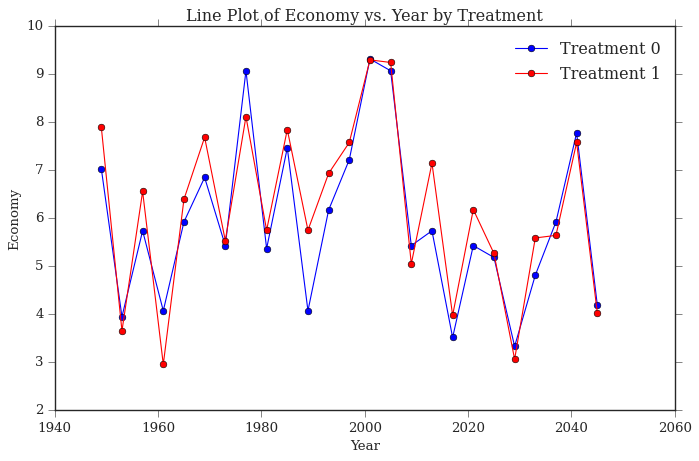

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Create separate dataframes for each treatment
df_treatment_0 = df_cum[df_cum['treatment'] == 0]
df_treatment_1 = df_cum[df_cum['treatment'] == 1]

# Create the line plot for Treatment 0 (blue)
plt.figure(figsize=(10, 6))
plt.plot(df_treatment_0['year'], df_treatment_0['economy'], label='Treatment 0', color='blue', marker='o')

# Create the line plot for Treatment 1 (red)
plt.plot(df_treatment_1['year'], df_treatment_1['economy'], label='Treatment 1', color='red', marker='o')

plt.xlabel('Year')
plt.ylabel('Economy')
plt.title('Line Plot of Economy vs. Year by Treatment')
plt.legend()

plt.show()


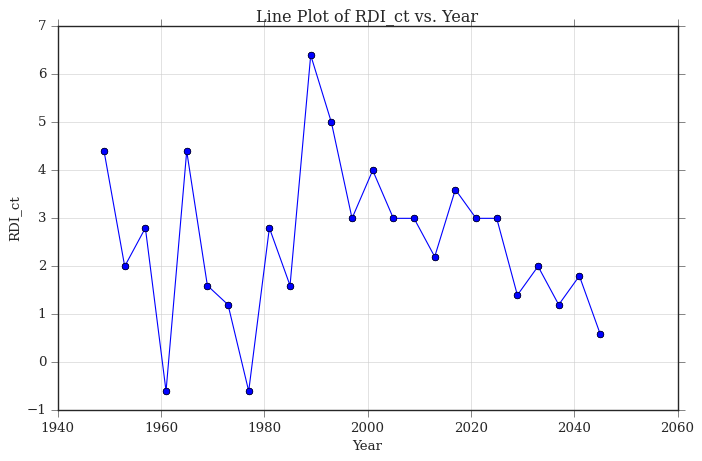

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data
df_cum = "https://www.dropbox.com/scl/fi/a1y5hd0skei1dxnicsokd/df_cum.csv?rlkey=lc6erjx2yycisrlg0ovk29igj&dl=1"
df_cum = pd.read_csv(df_cum)

# Create a line plot for RDI_ct over the years
plt.figure(figsize=(10, 6))
plt.plot(df_cum['year'], df_cum['RDI_ct'], color='blue', marker='o')

plt.xlabel('Year')
plt.ylabel('RDI_ct')
plt.title('Line Plot of RDI_ct vs. Year')
plt.grid(True)

plt.show()


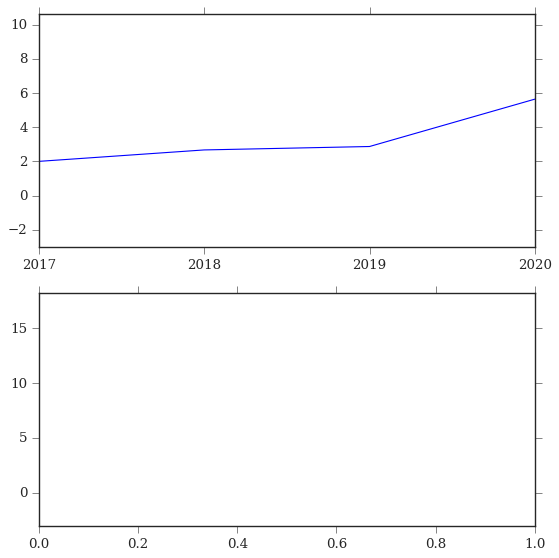

interactive(children=(IntSlider(value=2020, description='Election Year', max=2024, min=1964, step=4), Output()…

<function __main__.plot_growth(election_year)>

In [35]:
# Define a function to plot the RDI growth with a slider for election periods (For election year only)
def plot_growth(election_year):
    # Filter the data for the selected election period
    year_range = range(election_year - 3, election_year + 1)
    df_range = df.loc[df.index.isin(str(y) for y in year_range)]
    cumulative_range = df_range['growthvalue'].cumsum().sort_index()  # Change to 'growthvalue'

    # Define plot size and space
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].set_ylim(bottom=min(df_range['growthvalue']) - 5, top=max(df_range['growthvalue']) + 5)
    axs[1].set_ylim(bottom=min(cumulative_range) - 5, top=max(cumulative_range) + 5)

    # Plot the Yearly RDI growth for the selected period
    axs[0].plot(df_range.index, df_range['growthvalue'], label='Yearly')
    axs[0].set_title('Yearly Personal Income Growth for {}-{} ({})'.format(year_range[0], year_range[-1], presidents[election_year]), pad=20)
    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('% Change in Personal Income')
    axs[0].legend()

    for x, y in zip(df_range.index, df_range['growthvalue']):
        axs[0].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')  # Adjusted xytext to move data labels inside the plot space

    # Plot the Cumulative RDI growth for the selected period
    axs[1].plot(cumulative_range.index, cumulative_range, label='Cumulative')
    axs[1].set_title('Yearly Personal Income Growth for {}-{} ({})'.format(year_range[0], year_range[-1], presidents[election_year]), pad=20, fontsize=12)
    subtitle_text = "Each year adds the growth of all previous years, so the 4th Year shows the total growth from Years 1st-4th"
    axs[1].text(0.5, 1.01, subtitle_text, fontsize=10, ha='center', va='bottom', transform=axs[1].transAxes)
    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('% Change in Personal Income')
    axs[1].legend()

    for x, y in zip(cumulative_range.index, cumulative_range):
        axs[1].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    plt.tight_layout()
    plt.show()

# Create a slider for election years
election_slider = IntSlider(min=1964, max=2024, step=4, value=2020, description='Election Year')
interact(plot_growth, election_year=election_slider)